In [19]:
from datasets import  Dataset
from transformers import AutoTokenizer
from torch import Tensor
import pandas as pd

from utils import get_biggest_arts, MyArtist, get_all_artists
from bert_lightning import chunks_from_artists
MODEL_NAME = "distilbert/distilbert-base-multilingual-cased"

In [20]:
def split_into_year_buckets(l: list[float]) -> list[int]:
    buckets = []
    for year in l:
        if year < 2011:
            buckets.append(0)
        elif year < 2016:
            buckets.append(1)
        elif year < 2020:
            buckets.append(2)
        else:
            buckets.append(3)
    return buckets

In [21]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
arts = get_all_artists()
label2art = {label: i for i, label in enumerate((a.name_sanitized for a in arts))}
art2label = {i: label for label, i in label2art.items()}
arts = get_all_artists()
data = chunks_from_artists(arts, tokenizer, label2id=label2art, mode='solo', song_limit=190)

 84%|████████▍ | 886/1049 [00:06<00:00, 198.51it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7216b90fa140>>
Traceback (most recent call last):
  File "/home/tp/miniconda3/envs/mgr/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
100%|██████████| 1049/1049 [00:25<00:00, 41.28it/s]


In [ ]:
df = pd.DataFrame(data)
df['label'] = split_into_year_buckets(df['year'])
df = df[df['year'].between(1985, 2025)]
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df_dict = train_df.to_dict(orient='records')
test_df_dict = test_df.to_dict(orient='records')
test_dataset, train_dataset = Dataset.from_list(test_df_dict), Dataset.from_list(train_df_dict)

In [ ]:
label2id = {"before_2011": 0, "2011-2015": 1, "2016-2019": 2, "2020-2024": 3}
id2label = {i: label for label, i in label2id.items()}

In [ ]:
from transformers import DataCollatorWithPadding
import numpy as np
import evaluate
from transformers import AutoModelForSequenceClassification,  TrainingArguments, Trainer

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(label2id.keys()), id2label=id2label, label2id=label2id
        )
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
from torch.nn import functional as F


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = F.nll_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


batch_size = 12

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    # save_total_limit=1,
    load_best_model_at_end=True,
    # remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
train_output = trainer.train()
trainer.save_model("year_bert_classifier")

  0%|          | 0/11900 [00:00<?, ?it/s]

{'loss': 0.9036, 'grad_norm': 8.961231231689453, 'learning_rate': 3.8319327731092444e-05, 'epoch': 0.21}
{'loss': 0.8381, 'grad_norm': 5.451366901397705, 'learning_rate': 3.663865546218488e-05, 'epoch': 0.42}
{'loss': 0.8001, 'grad_norm': 11.484700202941895, 'learning_rate': 3.495798319327731e-05, 'epoch': 0.63}
{'loss': 0.745, 'grad_norm': 8.977151870727539, 'learning_rate': 3.3277310924369754e-05, 'epoch': 0.84}


  0%|          | 0/420 [00:00<?, ?it/s]

{'eval_loss': 1.0389797687530518, 'eval_accuracy': 0.5704365079365079, 'eval_runtime': 38.1158, 'eval_samples_per_second': 132.229, 'eval_steps_per_second': 11.019, 'epoch': 1.0}
{'loss': 0.6527, 'grad_norm': 10.89535903930664, 'learning_rate': 3.159663865546219e-05, 'epoch': 1.05}
{'loss': 0.6457, 'grad_norm': 22.455312728881836, 'learning_rate': 2.9915966386554626e-05, 'epoch': 1.26}
{'loss': 0.6578, 'grad_norm': 11.329472541809082, 'learning_rate': 2.8235294117647063e-05, 'epoch': 1.47}
{'loss': 0.6648, 'grad_norm': 10.956972122192383, 'learning_rate': 2.6554621848739497e-05, 'epoch': 1.68}
{'loss': 0.6673, 'grad_norm': 19.232940673828125, 'learning_rate': 2.4873949579831935e-05, 'epoch': 1.89}


  0%|          | 0/420 [00:00<?, ?it/s]

{'eval_loss': 1.0072017908096313, 'eval_accuracy': 0.5950396825396825, 'eval_runtime': 38.6312, 'eval_samples_per_second': 130.465, 'eval_steps_per_second': 10.872, 'epoch': 2.0}
{'loss': 0.5452, 'grad_norm': 16.488048553466797, 'learning_rate': 2.3193277310924373e-05, 'epoch': 2.1}
{'loss': 0.4538, 'grad_norm': 6.978675842285156, 'learning_rate': 2.1512605042016807e-05, 'epoch': 2.31}
{'loss': 0.4478, 'grad_norm': 12.019881248474121, 'learning_rate': 1.9831932773109244e-05, 'epoch': 2.52}
{'loss': 0.4507, 'grad_norm': 32.9630012512207, 'learning_rate': 1.8151260504201682e-05, 'epoch': 2.73}
{'loss': 0.4442, 'grad_norm': 13.77804946899414, 'learning_rate': 1.647058823529412e-05, 'epoch': 2.94}


  0%|          | 0/420 [00:00<?, ?it/s]

{'eval_loss': 1.2037444114685059, 'eval_accuracy': 0.6214285714285714, 'eval_runtime': 38.6205, 'eval_samples_per_second': 130.501, 'eval_steps_per_second': 10.875, 'epoch': 3.0}
{'loss': 0.3477, 'grad_norm': 24.387636184692383, 'learning_rate': 1.4789915966386557e-05, 'epoch': 3.15}
{'loss': 0.3062, 'grad_norm': 29.677471160888672, 'learning_rate': 1.3109243697478993e-05, 'epoch': 3.36}
{'loss': 0.297, 'grad_norm': 13.378599166870117, 'learning_rate': 1.1428571428571429e-05, 'epoch': 3.57}
{'loss': 0.3205, 'grad_norm': 7.786151885986328, 'learning_rate': 9.747899159663867e-06, 'epoch': 3.78}
{'loss': 0.3216, 'grad_norm': 20.73301887512207, 'learning_rate': 8.067226890756303e-06, 'epoch': 3.99}


  0%|          | 0/420 [00:00<?, ?it/s]

{'eval_loss': 1.5141355991363525, 'eval_accuracy': 0.608531746031746, 'eval_runtime': 38.2024, 'eval_samples_per_second': 131.929, 'eval_steps_per_second': 10.994, 'epoch': 4.0}
{'loss': 0.2295, 'grad_norm': 0.8541105389595032, 'learning_rate': 6.386554621848739e-06, 'epoch': 4.2}
{'loss': 0.2107, 'grad_norm': 9.249068260192871, 'learning_rate': 4.705882352941177e-06, 'epoch': 4.41}
{'loss': 0.2266, 'grad_norm': 13.747532844543457, 'learning_rate': 3.0252100840336137e-06, 'epoch': 4.62}
{'loss': 0.2186, 'grad_norm': 0.1875229924917221, 'learning_rate': 1.3445378151260504e-06, 'epoch': 4.83}


  0%|          | 0/420 [00:00<?, ?it/s]

{'eval_loss': 1.96645987033844, 'eval_accuracy': 0.620436507936508, 'eval_runtime': 36.1534, 'eval_samples_per_second': 139.406, 'eval_steps_per_second': 11.617, 'epoch': 5.0}
{'train_runtime': 3576.904, 'train_samples_per_second': 39.916, 'train_steps_per_second': 3.327, 'train_loss': 0.486259500840131, 'epoch': 5.0}


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = [point["label"] for point in test_dataset]

  0%|          | 0/420 [00:00<?, ?it/s]

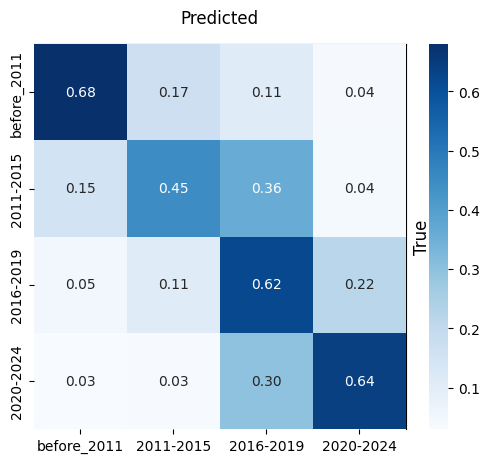

In [22]:
sklearn_confusion_matrix = confusion_matrix(
    list(true_labels), list(predicted_labels), labels=list(label2id.values())
)
# normalize the confusion matrix
sklearn_confusion_matrix = sklearn_confusion_matrix.astype("float") / sklearn_confusion_matrix.sum(axis=1)[:, np.newaxis]
fix, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    sklearn_confusion_matrix,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    xticklabels=list(label2id.keys()),
    yticklabels=list(label2id.keys()),
    ax = ax,
)

sec_x_ax = ax.secondary_xaxis("top")
sec_x_ax.set_xlabel("Predicted", fontsize=12, labelpad=15)
sec_x_ax.set_xticks([])
sec_y_ax = ax.secondary_yaxis("right")
sec_y_ax.set_ylabel("True", fontsize=12, labelpad=5)
sec_y_ax.set_yticks([])

plt.show()

In [23]:
model_loaded = AutoModelForSequenceClassification.from_pretrained("year_bert_classifier")
model_loaded

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [24]:
from transformers import pipeline
import shap
pred = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer, 
    return_all_scores=True,
    top_k=None,
    padding = True,
    truncation = True,
    device='cuda'
    )
explainer = shap.Explainer(pred)

In [25]:
texts = [tokenizer.decode(point["input_ids"], skip_special_tokens=True) for point in test_dataset]
shap_dataset = test_dataset.add_column("text", texts)

just_text = shap_dataset.remove_columns(["label","attention_mask", "input_ids", "year"])


In [ ]:
shap_values = explainer(just_text[:400])


In [25]:
shap.plots.bar(shap_values_all[0])

TypeError: The clustering provided by the Explanation object does not seem to be a partition tree, which is all shap.plots.bar supports.

before_2011


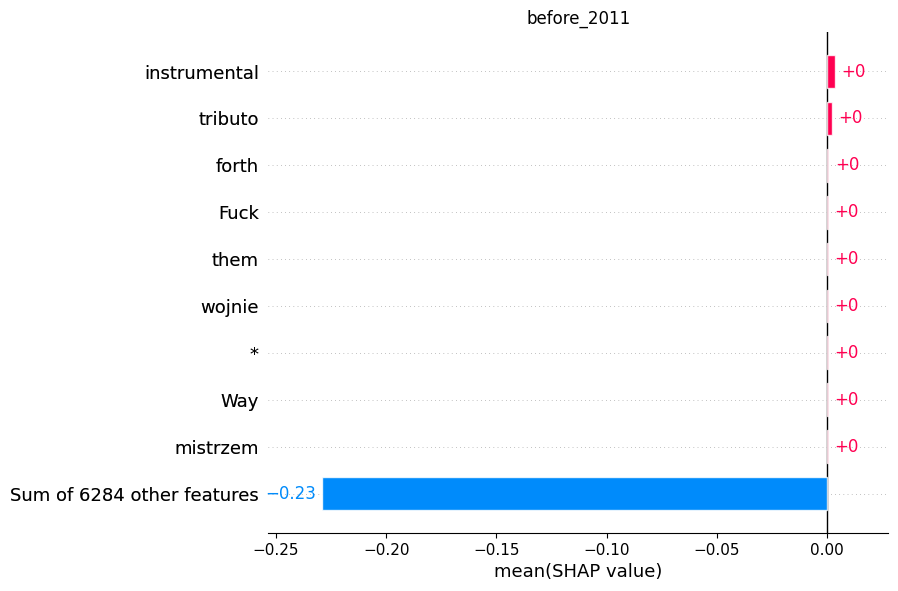

2011-2015


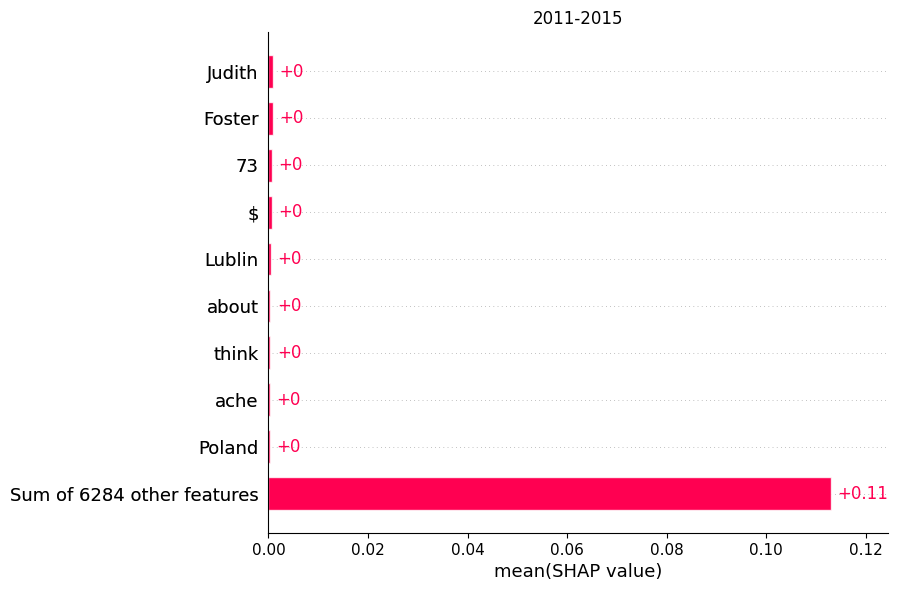

2016-2019


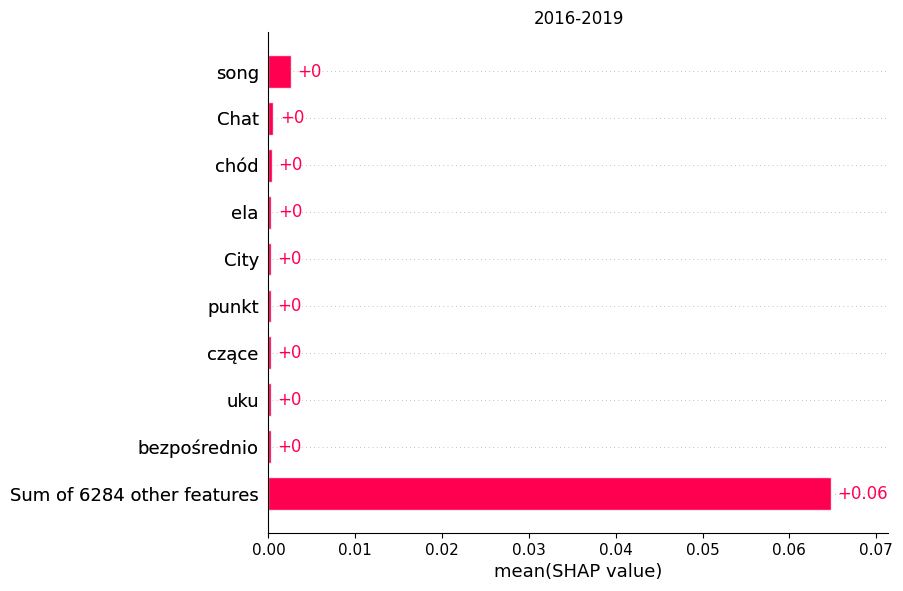

2020-2024


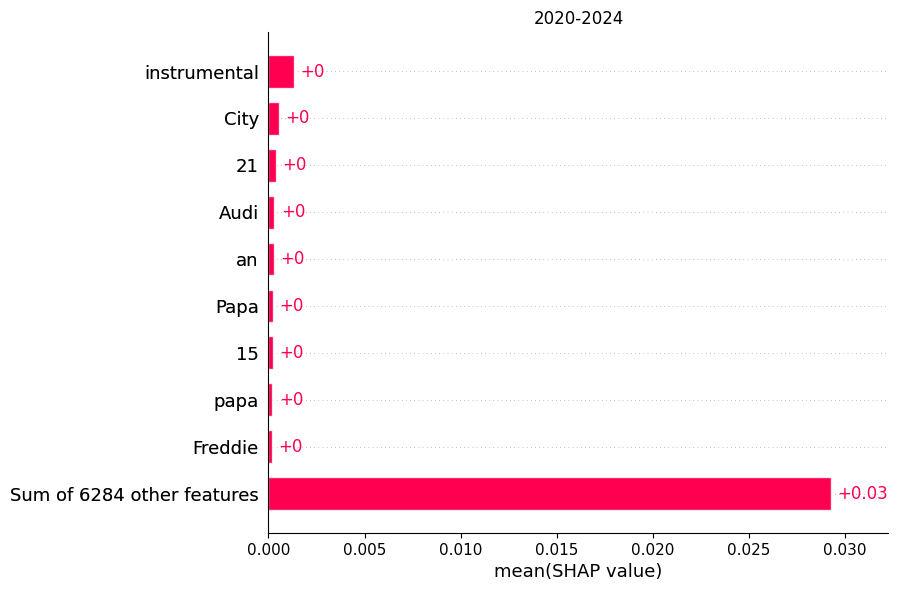

In [39]:
import matplotlib.pyplot as plt
from pathlib import Path
out_file = Path("plots/shap/")
out_file.mkdir(parents=True, exist_ok=True)
for name in label2id.keys():
    print(name)
    shap.plots.bar(shap_values[:, :, name].mean(0), order=shap.Explanation.argsort.flip, max_display=10, show=False)
    plt.title(name)
    f_name = out_file / f"{name}.png"
    plt.savefig(f_name, bbox_inches='tight')
    plt.savefig(f'plots/shap/shap_years{name}.png')
    plt.show()